In [1]:
import os
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
import cv2
import json
import torch
import numpy as np
import supervision as sv
import pycocotools.mask as mask_util
from pathlib import Path
from torchvision.ops import box_convert
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import sys
sys.path.append("../")
from grounding_dino.groundingdino.util.inference import load_model, load_image, predict

"""
Hyper parameters
"""
TEXT_PROMPT = "car. tire."
TEXT_PROMPT = "dog." 
IMG_PATH = "../notebooks/images/truck.jpg"
IMG_PATH = "../notebooks/images/unknown_image.jpg"
SAM2_CHECKPOINT = "../checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "../grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "../gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = Path("../outputs/grounded_sam2_local_demo")
DUMP_JSON_RESULTS = True

# create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# environment settings
# use bfloat16

# build SAM2 image predictor
sam2_checkpoint = SAM2_CHECKPOINT
model_cfg = SAM2_MODEL_CONFIG
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# build grounding dino model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

final text_encoder_type: bert-base-uncased


In [4]:
# setup the input image and text prompt for SAM 2 and Grounding DINO
# VERY important: text queries need to be lowercased + end with a dot
text = TEXT_PROMPT
img_path = IMG_PATH

image_source, image = load_image(img_path)

sam2_predictor.set_image(image_source)

boxes, confidences, labels = predict(
    model=grounding_model,
    image=image,
    caption=text,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
)

# process the box prompt for SAM 2
h, w, _ = image_source.shape
boxes = boxes * torch.Tensor([w, h, w, h])
input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


# FIXME: figure how does this influence the G-DINO model
# torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

#if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    #torch.backends.cuda.matmul.allow_tf32 = True
    #torch.backends.cudnn.allow_tf32 = True

masks, scores, logits = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

"""
Post-process the output of the model to get the masks, scores, and logits for visualization
"""
# convert the shape to (n, H, W)
if masks.ndim == 4:
    masks = masks.squeeze(1)


confidences = confidences.numpy().tolist()
class_names = labels

class_ids = np.array(list(range(len(class_names))))

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(class_names, confidences)
]

"""
Visualize image with supervision useful API
"""
img = cv2.imread(img_path)
detections = sv.Detections(
    xyxy=input_boxes,  # (n, 4)
    mask=masks.astype(bool),  # (n, h, w)
    class_id=class_ids
)

box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

label_annotator = sv.LabelAnnotator()
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
cv2.imwrite(os.path.join(OUTPUT_DIR, "groundingdino_annotated_image.jpg"), annotated_frame)

mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
cv2.imwrite(os.path.join(OUTPUT_DIR, "grounded_sam2_annotated_image_with_mask.jpg"), annotated_frame)

"""
Dump the results in standard format and save as json files
"""

def single_mask_to_rle(mask):
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

if DUMP_JSON_RESULTS:
    # convert mask into rle format
    mask_rles = [single_mask_to_rle(mask) for mask in masks]

    input_boxes = input_boxes.tolist()
    scores = scores.tolist()
    # save the results in standard format
    results = {
        "image_path": img_path,
        "annotations" : [
            {
                "class_name": class_name,
                "bbox": box,
                "segmentation": mask_rle,
                "score": score,
            }
            for class_name, box, mask_rle, score in zip(class_names, input_boxes, mask_rles, scores)
        ],
        "box_format": "xyxy",
        "img_width": w,
        "img_height": h,
    }
    
    with open(os.path.join(OUTPUT_DIR, "grounded_sam2_local_image_demo_results.json"), "w") as f:
        json.dump(results, f, indent=4)

Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).


In [5]:
sys.path.append("/share/u/wendler/code/my-sdxl-unbox")
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area_turbo
import torch
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image

# Load the Pipeline

dtype = torch.float16
pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    'stabilityai/sdxl-turbo',
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

# Load the SAEs
 
path_to_checkpoints = '/share/u/wendler/code/my-sdxl-unbox/checkpoints/'

code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k10_hidden5120_auxk256_bs4096_lr0.0001", "final"),
    )
    means = torch.load(
        os.path.join(path_to_checkpoints, f"{block}_k10_hidden5120_auxk256_bs4096_lr0.0001", "final", "mean.pt"),
        weights_only=True
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)
    means_dict[code] = means.to('cuda', dtype=dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [126]:
seed = 42
base_imgs1, cache1 = pipe.run_with_cache(
        "a photo of a black cat playing with a gun",
        positions_to_cache=[code_to_block["down.2.1"]],
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )

base_imgs2, cache2 = pipe.run_with_cache(
        "a photo of a dog playing with a ball",
        positions_to_cache=[code_to_block["down.2.1"]],
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )

In [135]:
from matplotlib import pyplot as plt
from typing import Tuple
import grounding_dino.groundingdino.datasets.transforms as T

def sam_mask(img, prompt):
    def load_image(img) -> Tuple[np.array, torch.Tensor]:
        transform = T.Compose(
            [
                T.RandomResize([800], max_size=1333),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        image_source = img.convert("RGB")
        image = np.asarray(image_source)
        image_transformed, _ = transform(image_source, None)
        return image, image_transformed
    image_source, image = load_image(img)
    sam2_predictor.set_image(image_source)

    boxes, confidences, labels = predict(
        model=grounding_model,
        image=image,
        caption=prompt,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
    )

    # process the box prompt for SAM 2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


    # FIXME: figure how does this influence the G-DINO model
    # torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    #if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        #torch.backends.cuda.matmul.allow_tf32 = True
        #torch.backends.cudnn.allow_tf32 = True

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    """
    Post-process the output of the model to get the masks, scores, and logits for visualization
    """
    # convert the shape to (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)


    confidences = confidences.numpy().tolist()
    class_names = labels

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(class_names, confidences)
    ]

    detections = sv.Detections(
        xyxy=input_boxes,  # (n, 4)
        mask=masks.astype(bool),  # (n, h, w)
        class_id=class_ids
    )

    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    label_annotator = sv.LabelAnnotator()
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    mask_annotator = sv.MaskAnnotator()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    plt.imshow(annotated_frame)
    plt.show()
    return detections, labels
    

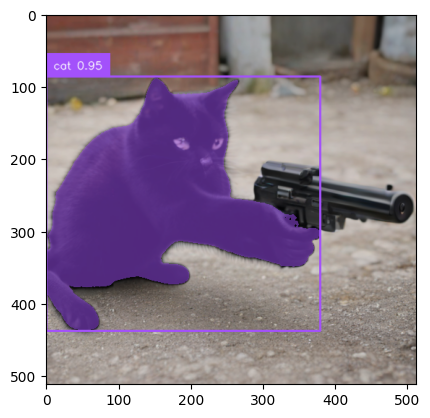

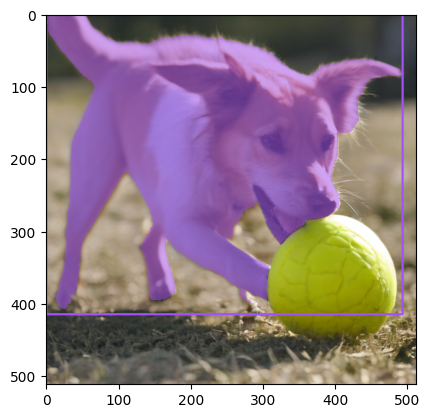

In [136]:
detections1, labels1 = sam_mask(base_imgs1[0][0], "cat.")
detections2, labels2 = sam_mask(base_imgs2[0][0], "dog.")

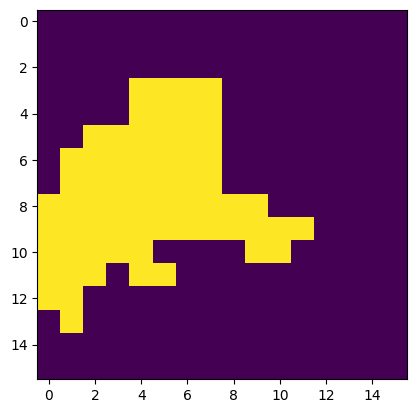

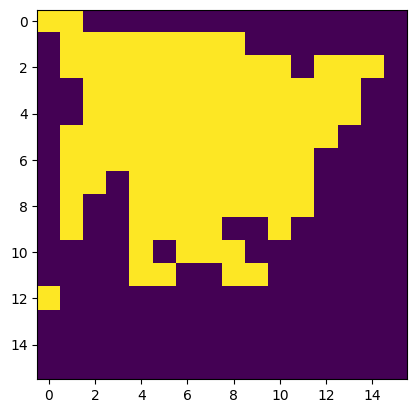

In [137]:
def resize_mask(mask, size=(16, 16)):
    return cv2.resize(mask.astype(np.uint8), size, interpolation=cv2.INTER_LANCZOS4) > 0

mask1 = resize_mask(detections1.mask[0])
mask2 = resize_mask(detections2.mask[0])

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

In [164]:
# cat latents
diff = cache1['output'][code_to_block["down.2.1"]][0] - cache1['input'][code_to_block["down.2.1"]][0]
print(mask1.sum())
cat = diff[:, :, mask1]
print(cat.shape)
# dog latents
diff = cache2['output'][code_to_block["down.2.1"]][0] - cache2['input'][code_to_block["down.2.1"]][0]
print(mask2.sum())
dog = diff[:, :, mask2]
print(dog.shape)

layer = "up.0.0"
sae = saes_dict[layer]

cat_feats = sae.encode(cat.permute(0, 2, 1))
dog_feats = sae.encode(dog.permute(0, 2, 1))

65
torch.Size([1, 1280, 65])
104
torch.Size([1, 1280, 104])


In [165]:
print(cat_feats.shape, dog_feats.shape)
# use fisher criterion to select the best features to transfer information from cat to dog
mean_cat = cat_feats[0].mean(dim=0)
mean_dog = dog_feats[0].mean(dim=0)
std_cat = cat_feats[0].std(dim=0)
std_dog = dog_feats[0].std(dim=0)
print(mean_cat)
print(mean_dog)
fisher_cat = (mean_cat - mean_dog) #/ (std_cat + std_dog + 1e-6)
fisher_dog = (mean_dog - mean_cat) #/ (std_dog + std_cat + 1e-6)

best_features = np.argsort(fisher_cat.cpu().detach().numpy())[::-1][:10].copy()

print(best_features)

print(mean_cat.shape)
print("mean std", mean_cat.mean(), mean_cat.std(), mean_cat.max(), mean_cat.min())
mean_vals = mean_cat[best_features]
std_vals = std_cat[best_features]
print(mean_cat, std_cat)
print(mean_dog[best_features], std_dog[best_features])

torch.Size([1, 65, 5120]) torch.Size([1, 104, 5120])
tensor([0.0000, 0.0000, 0.0000,  ..., 2.0938, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float16, grad_fn=<MeanBackward1>)
tensor([0.0000, 0.0000, 0.0000,  ..., 6.1719, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float16, grad_fn=<MeanBackward1>)
[3579 4694 4939 1519   34 2533 1717 4013 3394 1492]
torch.Size([5120])
mean std tensor(0.0301, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>) tensor(0.5498, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>) tensor(20.7500, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>)
tensor([0.0000, 0.0000, 0.0000,  ..., 2.0938, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float16, grad_fn=<MeanBackward1>) tensor([0.0000, 0.0000, 0.0000,  ..., 4.6875, 0.0000, 0.0000], device='cuda:0',
       dtype=torch.float16, grad_fn=<StdBackward0>)
tensor([ 0.3989,  3.5020, 15.0

(16, 16) torch.Size([10]) outs


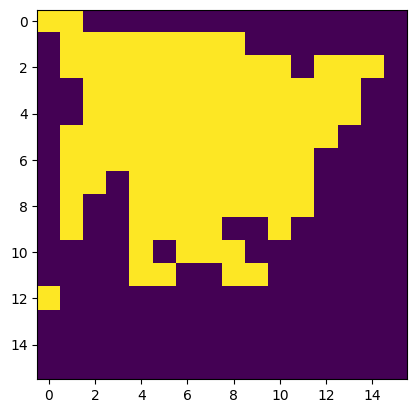

tensor([ 7.6719, 10.1016, 20.7500,  4.7266,  3.6270,  7.0273,  5.9453,  4.2305,
         1.9727,  4.0273], device='cuda:0', dtype=torch.float16,
       grad_fn=<IndexBackward0>)
torch.Size([1, 16, 16, 5120])
torch.Size([1, 16, 16, 5120])
torch.Size([1, 16, 16, 5120])
torch.Size([1, 16, 16, 5120])


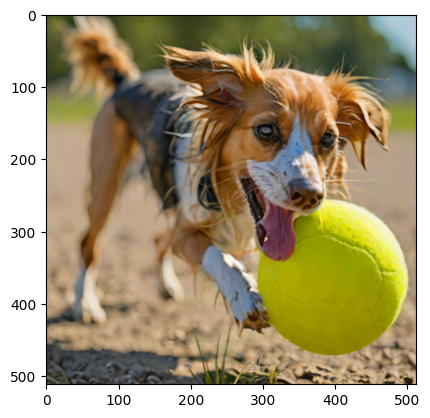

In [167]:
@torch.no_grad()
def add_featuremaps(sae, feature_idcs, fmaps, module, input, output):
    diff = output[0] - input[0]
    coefs = sae.encode(diff.permute(0, 2, 3, 1))
    my_coefs = coefs[..., feature_idcs]
    print(my_coefs.shape, fmaps.shape, )
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    print(mask.shape)
    mask[..., feature_idcs] += fmaps.to(mask.device) - my_coefs
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    print("hi")
    return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

@torch.no_grad()
def add_featuremaps_steering(sae, fmaps, module, input, output):
    print(fmaps.shape)
    to_add = fmaps.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

feature_idcs = best_features
fmaps = torch.zeros((1, 16,16, len(fisher_cat)), device='cuda')
fmaps[:, mask2] += 10*fisher_cat.unsqueeze(0).unsqueeze(0)
fmaps.cuda()
print(mask2.shape, mean_vals.shape, 'outs')
plt.imshow(mask2)
plt.show()
print(mean_vals)
result = pipe.run_with_hooks(
        "a photo of a dog playing with a ball",
        position_hook_dict={
            code_to_block[layer]: lambda *args, **kwargs: add_featuremaps_steering(sae, fmaps, *args, **kwargs)
        },
        num_inference_steps=4,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed)
    ).images[0]

plt.imshow(result)
plt.show()